### Importering av bibliotek

In [442]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spectral
from PIL import Image
import os
import glob
from ipywidgets import interact
import ipywidgets as widgets
from matplotlib.colors import LinearSegmentedColormap

### Funksjoner

In [443]:
def calibrate_wavelengths(ImageWidth, Spectral_lines, Pixel_positions, Degree, Output_file):
    """
    Calibrate pixel positions to wavelengths.

    Parameters:
    - ImageWidth: int, number of pixels.
    - Spectral_lines: list of float, spectral lines or known wavelengths in nm.
    - Pixel_positions: list of int, pixel positions corresponding to the known spectral lines.
    - Degree: int, degree of the polynomial fit (1 for linear).
    - Output_file: str, path to the output CSV file.

    Returns:
    - df: pandas DataFrame, containing pixel positions and calibrated wavelengths.
    """
    if len(Spectral_lines) != len(Pixel_positions):
        raise ValueError("The number of wavelengths must match the number of pixel positions.")
    if len(Spectral_lines) < 2:
        raise ValueError("At least two wavelengths and pixel positions are required for calibration.")

    # Fit a polynomial function to the known wavelengths at the pixel positions
    wavelength_fit = np.polyfit(Pixel_positions, Spectral_lines, Degree)
    wavelength_calibration = np.poly1d(wavelength_fit)

    # Calibrate the pixel positions to wavelengths
    calibrated_wavelengths = wavelength_calibration(np.arange(ImageWidth))

    # Create a DataFrame
    df = pd.DataFrame({
        'Pixel Position': np.arange(len(calibrated_wavelengths)),
        'Calibrated Wavelength (nm)': calibrated_wavelengths
    })

    # Save the DataFrame to a CSV file
    df.to_csv(Output_file, index=False)
    return df

def expected_irradiance(B_0):
    R = 0.92
    r_0 = 0.5 # from source to lambertian surface
    alpha = 0 # angle between source and normal to lambert
    p = 0.98 # diffusion coefficient of lambertian surface
    B_expected = B_0*(r_0/R)**2*p*np.cos(alpha) # photons/cm^2/s/Å

    return B_expected

def read_bip_file(file_path, width, height):
    with open(file_path, 'rb') as file:
        data = file.read()
    
    # Konverter binærdata til numpy array med 8-bit unsigned integers
    raw_data = np.frombuffer(data, dtype=np.uint8)
    
    # Kombiner 8-bit verdier til 16-bit verdier
    total_pixels = width * height
    pixel_data = np.zeros(total_pixels, dtype=np.uint16)
    
    for i in range(total_pixels):
        byte_index = i * 2
        pixel_data[i] = (raw_data[byte_index] << 8) | raw_data[byte_index + 1]
    
    # Reshape array til 2D bilde
    image = pixel_data.reshape((height, width))
    return image

def calculate_average_image(file_paths, output_path, width, height):
    """
    Calculates the average image from a list of .bip file paths.
    """
    images = [read_bip_file(file_path, width, height) for file_path in file_paths]
    average_image = np.mean(images, axis=0)

    image_data = average_image
    
    np.savetxt(output_path, image_data, delimiter=',', fmt='%d')

def find_consecutive_range_means(arr):
    """
    Finds the mean of consecutive ranges in an array of integers.

    Parameters:
    - arr: numpy array of integers.

    Returns:
    - means: list of floats, each representing the mean of a consecutive range.
    """
    means = []
    start = arr[0]
    current_range = [start]
    
    for i in range(1, len(arr)):
        if arr[i] != arr[i-1] + 1:
            means.append(np.mean(current_range))
            current_range = [arr[i]]
        else:
            current_range.append(arr[i])
    
    # Append the mean of the last range
    means.append(np.mean(current_range))
    
    return means

def pix_to_wavelength(spectrogram, csv_file='Data/Calibrated/calibrated_wavelengths.csv', wavelength_min=None, wavelength_max=None):
    """
    Crop the spectrogram to a specific wavelength range.

    Args:
        spectrogram (np.ndarray): The spectrogram data.
        csv_file (str): Path to the CSV file containing the calibrated wavelengths.
        wavelength_min (float): Minimum wavelength to crop to.
        wavelength_max (float): Maximum wavelength to crop to.
    """
    # Read the CSV file to get the calibrated wavelengths
    df = pd.read_csv(csv_file)
    wavelengths = df.iloc[:, 1].values

    # Set the default wavelength range if not provided
    if wavelength_min is None:
        wavelength_min = 380
    if wavelength_max is None:
        wavelength_max = 800

    # Crop the wavelengths and the corresponding image data
    valid_indices = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
    cropped_wavelengths = wavelengths[valid_indices]
    cropped_spectrogram = spectrogram[:, valid_indices]

    return cropped_spectrogram, cropped_wavelengths

def plot_visible_spectrum_cmap(spectrogram, wavelengths):
    """
    Plot the spectrogram with the visible spectrum on the wavelength axis.

    Args:
        spectrogram (np.ndarray): The spectrogram data.
        wavelengths (np.ndarray): The calibrated wavelengths.
    """
    # Create the visible spectrum colormap
    colors = [
        (0.0, 0.0, 0.5),  # 380 nm (violet)
        (0.0, 0.0, 1.0),  # 450 nm (blue)
        (0.0, 1.0, 1.0),  # 495 nm (cyan)
        (0.0, 1.0, 0.0),  # 570 nm (green)
        (1.0, 1.0, 0.0),  # 590 nm (yellow)
        (1.0, 0.5, 0.0),  # 620 nm (orange)
        (1.0, 0.0, 0.0),  # 700 nm (red)
        (0.5, 0.0, 0.0)   # 800 nm (deep red)
    ]

    # Create the colormap
    visible_spectrum_cmap = LinearSegmentedColormap.from_list('visible_spectrum', colors, N=256)
    
    # Plot the spectrogram with grayscale intensity
    plt.figure(figsize=(20, 14))
    extent = [wavelengths.min(), wavelengths.max(), 0, spectrogram.shape[0]]
    plt.imshow(spectrogram, cmap='gray', aspect='auto', extent=extent)
    plt.colorbar(label='intensity [counts]')

    # Create a secondary x-axis with the visible spectrum colormap
    ax = plt.gca()
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=visible_spectrum_cmap), ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_ticks([])

    plt.xlabel('Wavelength (nm)')
    plt.xticks(np.arange(380, 801, 20))
    plt.ylabel('Pixel Position')
    plt.title('Calibrated Spectrogram with Visible Spectrum')
    plt.show()

def remove_noise(image, dark_image):
    """
    Remove noise from an image by subtracting the dark image (noise) and ensuring no values fall below 0.

    Args:
        image (np.ndarray): The input image from which noise is to be removed.
        dark_image (np.ndarray): The dark image representing the noise.

    Returns:
        np.ndarray: The denoised image with no values below 0.
    """
    # Subtract the dark image (noise) from the input image
    denoised_image = image - dark_image
    
    # Ensure no values fall below 0
    denoised_image = np.maximum(denoised_image, 0)
    
    return denoised_image


    

### Bølgelengde Kalibrering

In [444]:
PixelWidth = 1936
PixelHeight = 1216

H_paths = glob.glob(os.path.join('Data/H/', '*.bip')) # Eksponering 50 ms
He_paths = glob.glob(os.path.join('Data/HE/', '*.bip')) # Eksponering 30 ms
Hg_paths = glob.glob(os.path.join('Data/HG/', '*.bip')) # Eksponering 100 ms

H_avg_img_path = 'Data/Average/H_avg.txt'
He_avg_img_path = 'Data/Average/He_avg.txt'
Hg_avg_img_path = 'Data/Average/Hg_avg.txt'

## Calculate average images
#calculate_average_image(H_paths, H_avg_img_path, PixelWidth, PixelHeight)
#calculate_average_image(He_paths, He_avg_img_path, PixelWidth, PixelHeight)
#calculate_average_image(Hg_paths, Hg_avg_img_path, PixelWidth, PixelHeight)

In [445]:
# Read average images
H_avg_img = np.loadtxt(H_avg_img_path, delimiter=',')
He_avg_img = np.loadtxt(He_avg_img_path, delimiter=',')
Hg_avg_img = np.loadtxt(Hg_avg_img_path, delimiter=',')

In [468]:
img = H_avg_img # Choose image to display

threshold = np.percentile(img, 99) 
spectral_lines = np.where(img > threshold)

unique_x_values = np.unique(spectral_lines[1])
spectralPeaks = find_consecutive_range_means(unique_x_values) # Approximate spectral peaks
print("Spectral Peaks: ", spectralPeaks)

def plot_image(xline=0, yline=0):
    plt.figure(figsize=(30, 14))
    plt.imshow(img, cmap='gray', extent=[0, img.shape[1], 0, img.shape[0]])
    plt.colorbar()
    plt.title('16-bit Image')
    plt.xticks(np.arange(0, img.shape[1], 100))
    plt.axvline(x=xline, color='red')  # Add vertical line at xline
    plt.axhline(y=yline, color='blue')
    plt.show()

# Create interactive widgets for x and y coordinates, pixel width, and pixel height
x_widget = widgets.IntText(value=0, description='X Line:')
y_widget = widgets.IntText(value=681, description='Y Line:')

# Use interact to create the interactive plot
interact(plot_image, xline=x_widget, yline=y_widget)

Spectral Peaks:  [16.5, 25.0, 58.0, 259.0, 300.5, 443.5, 551.0, 651.0, 723.0, 735.0, 869.0, 909.5, 948.0, 1142.0, 1249.0, 1541.0, 1588.0, 1673.0, 1680.0, 1769.0, 1869.0]


interactive(children=(IntText(value=0, description='X Line:'), IntText(value=681, description='Y Line:'), Outp…

<function __main__.plot_image(xline=0, yline=0)>

In [447]:
Spectral_lines = [486.1, 656.3, 587.5, 435.8] # 2 Hydrogen (H), 1 Helium (He), 1 Mercury (Hg) # [486.1, 656.3, 587.5, 435.8]
pixel_positions = [443, 909, 720, 306]  # [443, 909, 720, 306]
degree = 1
output_file = 'Data/Calibrated/calibrated_wavelengths.csv'

df = calibrate_wavelengths(PixelWidth, Spectral_lines, pixel_positions, degree, output_file)


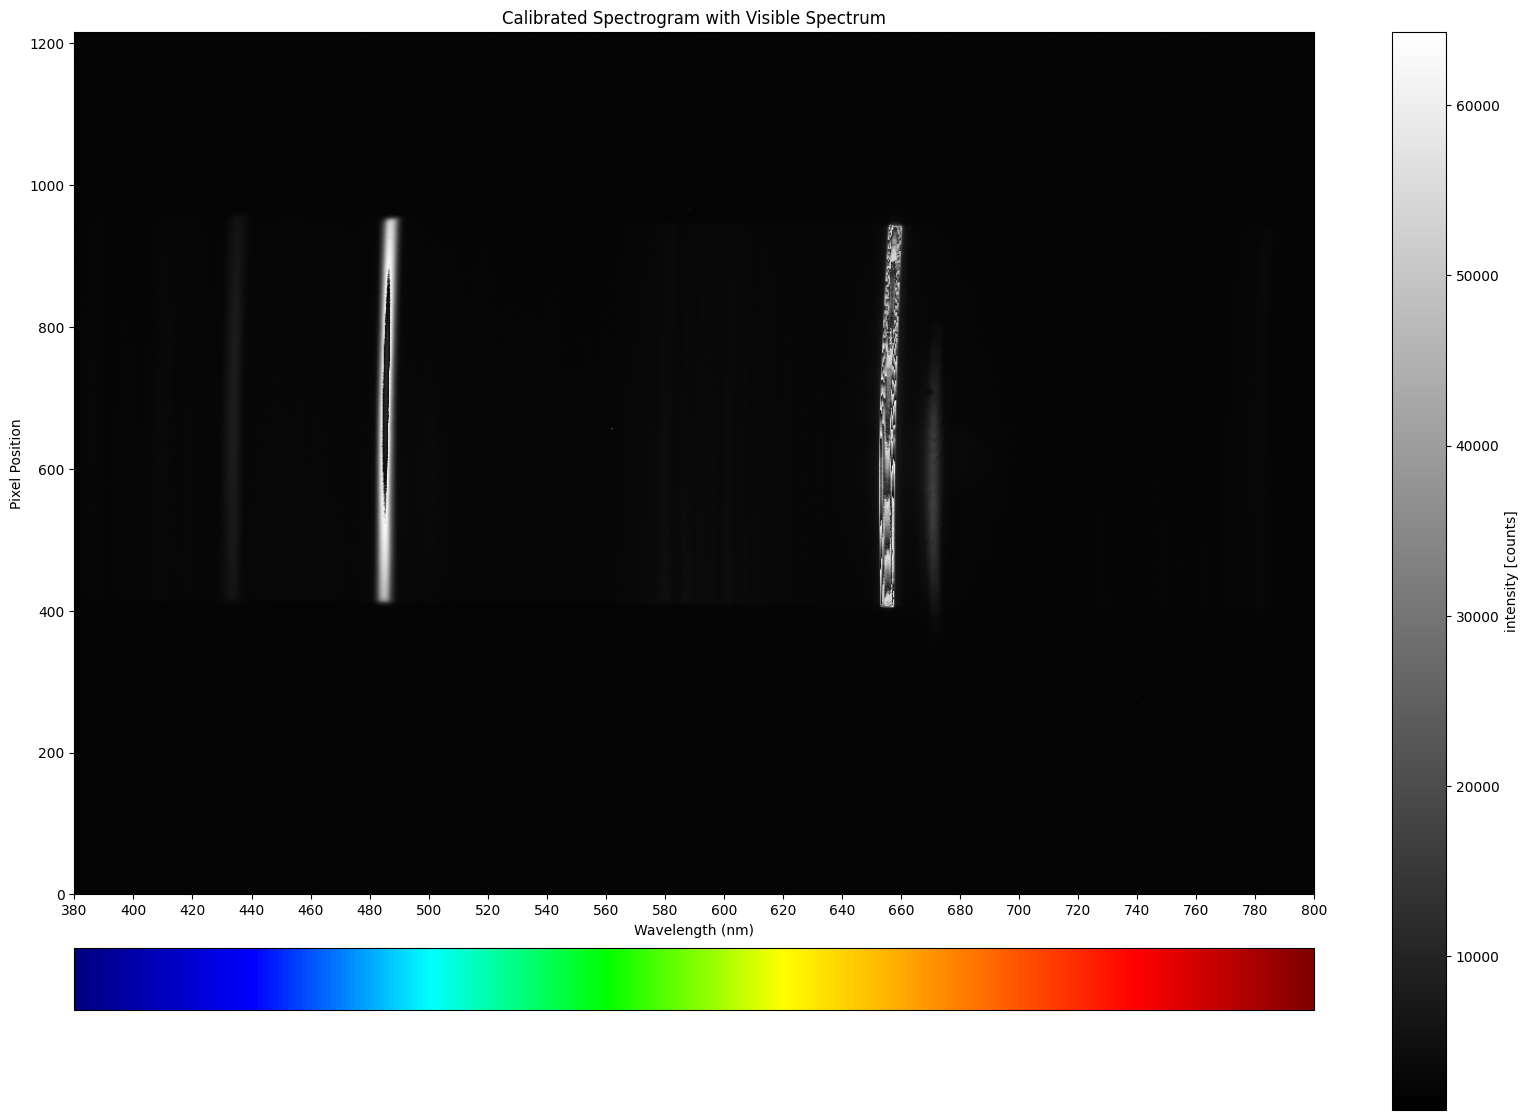

In [448]:
spec, wave = pix_to_wavelength(H_avg_img, csv_file='Data/Calibrated/calibrated_wavelengths.csv')

plot_visible_spectrum_cmap(spec, wave)

### Intensitet Kalibrering

In [449]:
#Data paths

dark_paths_e50 = glob.glob(os.path.join('Data/dark-images/E50/', '*.bip')) # Eksponering 50 ms
dark_paths_e100 = glob.glob(os.path.join('Data/dark-images/E100/', '*.bip')) # Eksponering 100 ms
dark_paths_e300 = glob.glob(os.path.join('Data/dark-images/E300/', '*.bip')) # Eksponering 200 ms
dark_paths_e450 = glob.glob(os.path.join('Data/dark-images/E450/', '*.bip')) # Eksponering 450 ms
dark_paths_e500 = glob.glob(os.path.join('Data/dark-images/E500/', '*.bip')) # Eksponering 500 ms
dark_paths_e1000 = glob.glob(os.path.join('Data/dark-images/E1000/', '*.bip')) # Eksponering 1000 ms

B_measured_200W_E100_paths = glob.glob(os.path.join('Data/MeasuredIntensity/200W/E100/', '*.bip')) # 200W, Eksponering 100 ms
B_measured_200W_E500_paths = glob.glob(os.path.join('Data/MeasuredIntensity/200W/E500/', '*.bip')) # 200W, Eksponering 500 ms
B_measured_200W_E1000_paths = glob.glob(os.path.join('Data/MeasuredIntensity/200W/E1000/', '*.bip')) # 200W, Eksponering 1000 ms

B_measured_1000W_E100_paths = glob.glob(os.path.join('Data/MeasuredIntensity/1000W/E100/', '*.bip')) # 1000W, Eksponering 100 ms
B_measured_1000W_E300_paths = glob.glob(os.path.join('Data/MeasuredIntensity/1000W/E300/', '*.bip')) # 1000W, Eksponering 300 ms
B_measured_1000W_E450_paths = glob.glob(os.path.join('Data/MeasuredIntensity/1000W/E450/', '*.bip')) # 1000W, Eksponering 450 ms

In [450]:
## Average measured data
# calculate_average_image(B_measured_200W_E100_paths, 'Data/Average/E100/B_200W_E100_avg.txt', PixelWidth, PixelHeight)
# calculate_average_image(dark_paths_e100, 'Data/Average/E100/Dark_Image_E100_avg.txt', PixelWidth, PixelHeight)

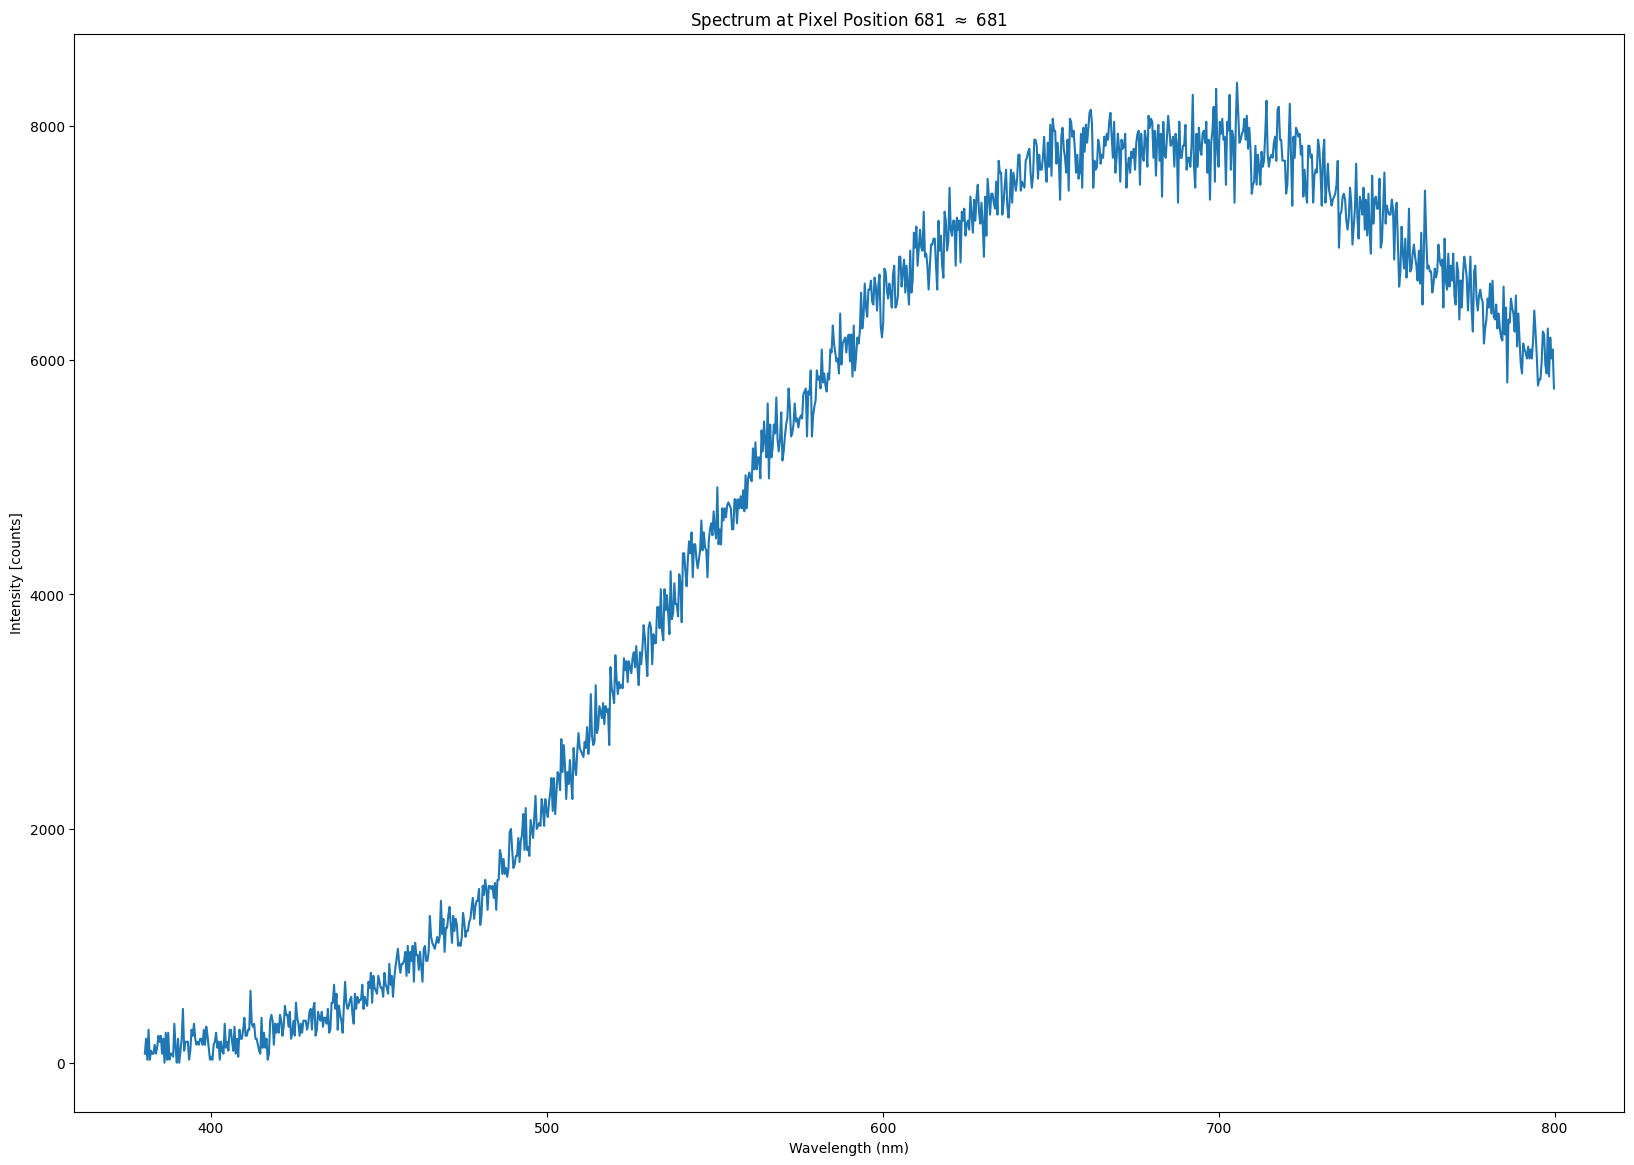

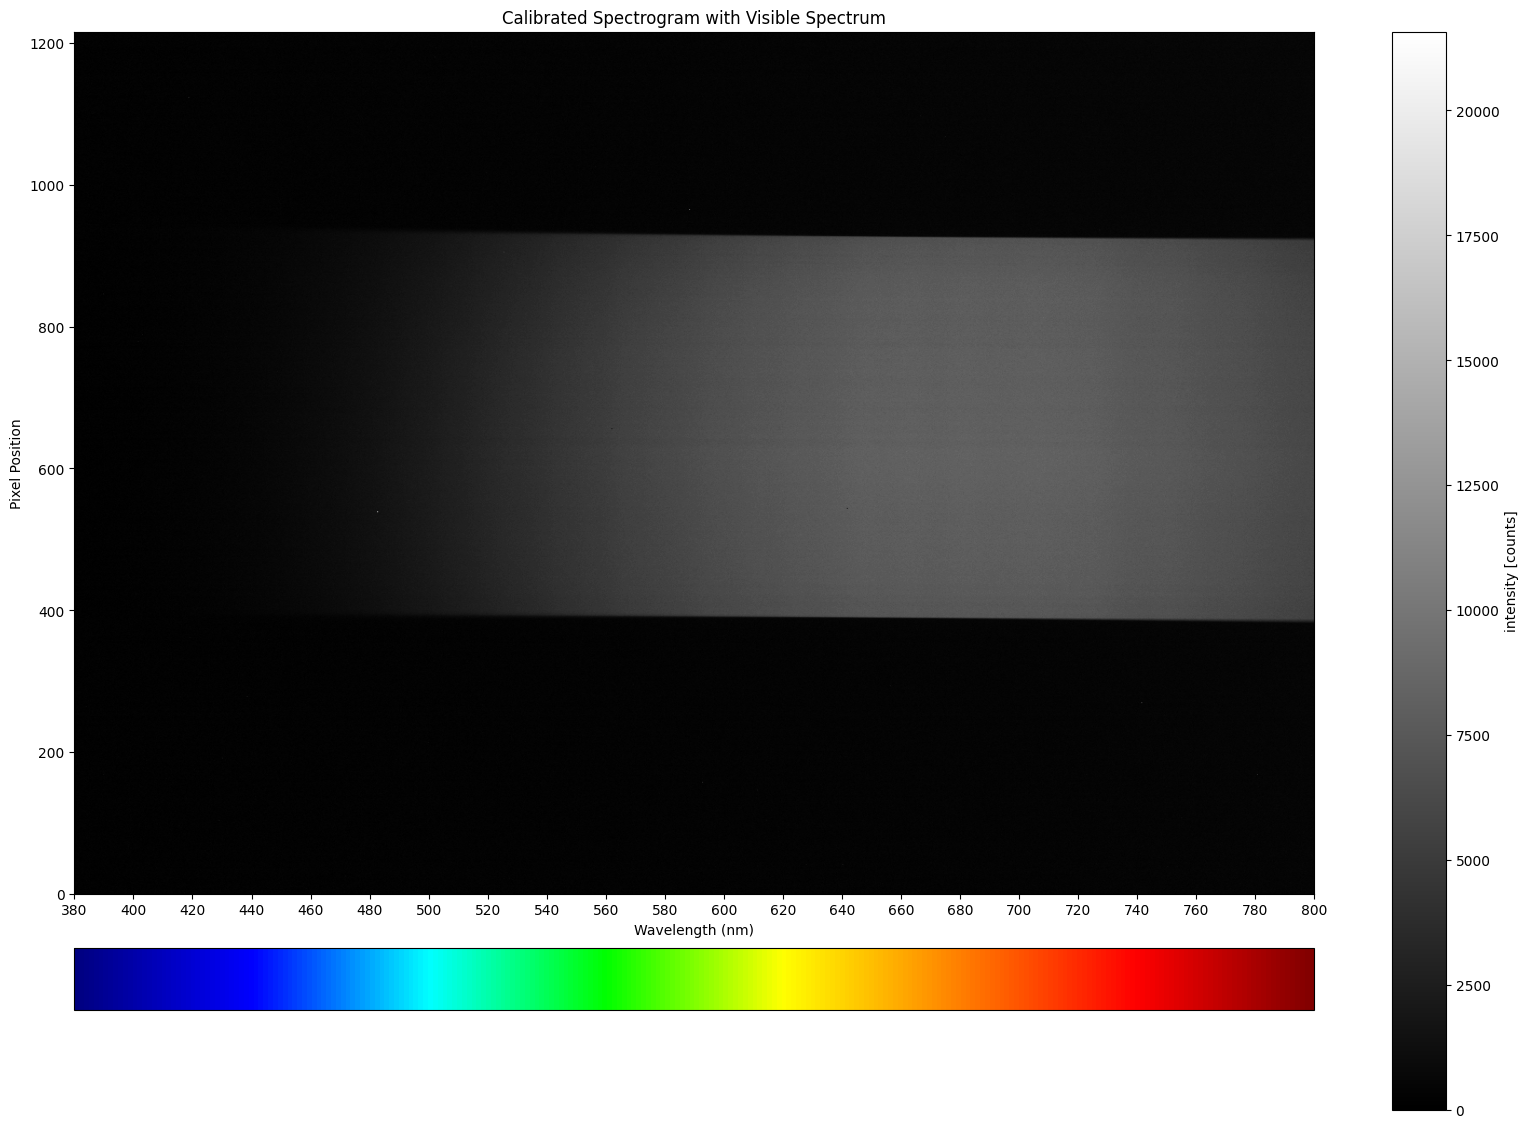

In [470]:
# Measured data
B_200W_E100_avg = np.loadtxt('Data/Average/E100/B_200W_E100_avg.txt', delimiter=',')
Dark_Image_E100_avg = np.loadtxt('Data/Average/E100/Dark_Image_E100_avg.txt', delimiter=',')

B_200W_E100_Noiseless = remove_noise(B_200W_E100_avg, Dark_Image_E100_avg)

spec, wave = pix_to_wavelength(B_200W_E100_Noiseless, csv_file='Data/Calibrated/calibrated_wavelengths.csv')

PixMid = (956-406) // 2 + 406 # Midpoint of the image with spectral values (406, 956) ~ 681, from the plot above

B_200W_E100_fwhm = spec[PixMid, :]

plt.figure(figsize=(20, 14))
plt.plot(wave, B_200W_E100_fwhm)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity [counts]')
plt.title(rf'Spectrum at Pixel Position {PixMid} $\approx$ 681')
plt.show()

plot_visible_spectrum_cmap(spec, wave)

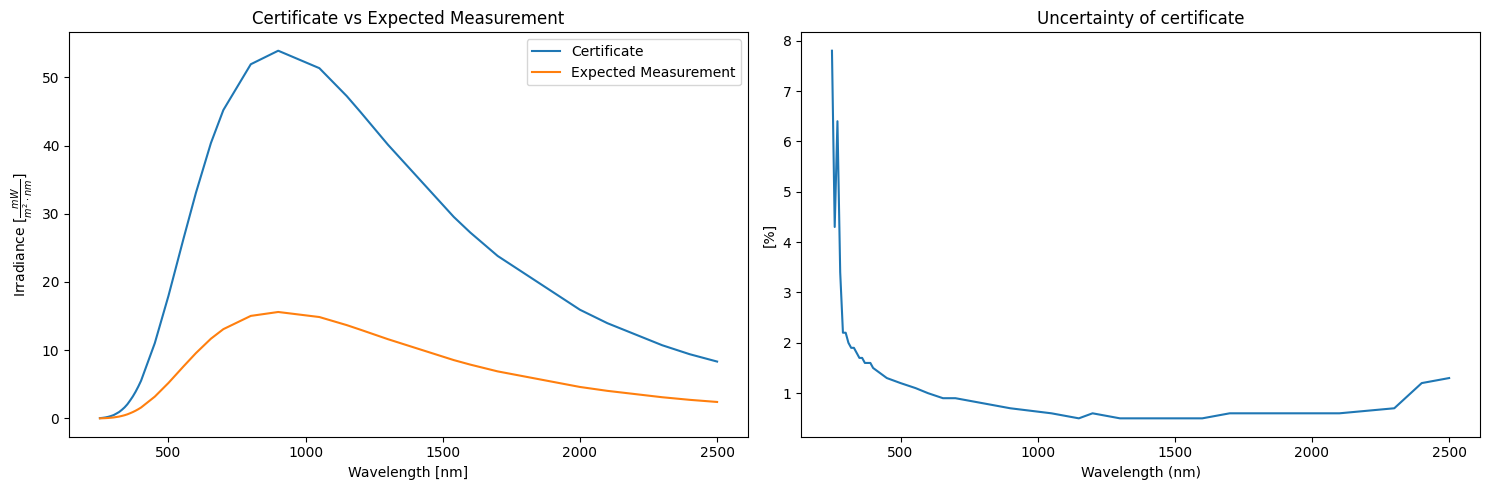

In [461]:
#Certificate data
W_L = np.loadtxt('Data/Calibrated/calibrationCertificate200W.txt', usecols=0) # Wavelengths in nm
B_0 = np.loadtxt('Data/Calibrated/calibrationCertificate200W.txt', usecols=1) # Irradiance in mW/m^2/nm
sigma = np.loadtxt('Data/Calibrated/calibrationCertificate200W.txt', usecols=2) # Uncertainty in %


B_expected = expected_irradiance(B_0)

# plot B_0
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))

# First subplot
ax1.plot(W_L, B_0, label='Certificate')
ax1.plot(W_L, B_expected, label='Expected Measurement')
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel(r'Irradiance [$\frac{mW}{m^2\cdot nm}$]')
ax1.legend()
ax1.set_title('Certificate vs Expected Measurement')

# Second subplot
ax2.plot(W_L, sigma)
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('[%]')
ax2.set_title('Uncertainty of certificate')

# Adjust layout
plt.tight_layout()
plt.show()